In [1]:
import sys
import os
sys.path.insert(0, '/Users/james/Desktop/DRL_Hedging/')

import numpy as np
import torch
import matplotlib.pyplot as plt
from financial_models.asset_price_models import GBM, StochasticVolatilityModel
from financial_models.option_price_models import BSM, BSMSABR
from torch import nn
from hedging_env_gymnasium_a import HedgingEnv
from Utils import NormalizeObservationWrapper, evaluate_drl_policy

from stable_baselines3 import SAC, DDPG
from tqdm import tqdm
import seaborn as sns


seed = 345
np.random.seed(seed)
torch.manual_seed(seed)

mu = 0
D = 5
T = 10
num_steps = T*D
s_0 = 100
strike_price = s_0
sigma = 0.15
r = 0
trading_cost_para=0.003
L=100
v=0.6
rho=-0.4

apm = StochasticVolatilityModel(mu=mu, v=v, rho=rho, dt = 1/(252*D), s_0=s_0, sigma_0=sigma)
opm = BSMSABR(strike_price=strike_price, risk_free_interest_rate=r, T=T/252, dt=1/(252*D),v=v, rho=rho)
env = HedgingEnv(asset_price_model=apm, D=D, T=T, num_steps=num_steps, trading_cost_para=trading_cost_para,r=r,
                L=L, strike_price=strike_price, initial_holding_delta=False, mode="PL",
                option_price_model=opm)

env_id = "hedging_env_gymnasium"


/Users/james/Desktop/DRL_Hedging/financial_models/option_price_models.py:78: RuntimeWarning: invalid value encountered in double_scalars
  SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)


In [2]:
state, info = env.reset()
liability = state[3]*L

In [3]:
normalized_env = NormalizeObservationWrapper(env)

In [4]:
import numpy as np
from tqdm import tqdm
model_path = "./trained_models"
save_path = "./result_analysis"

# Load the trained models
model_sac = SAC.load(f"{model_path}/sac_final_sabr_3e-3")
model_ddpg = DDPG.load(f"{model_path}/ddpg_final_sabr_3e-3")




In [5]:
sac_rewards,sac_costs,_ = evaluate_drl_policy(normalized_env,model_sac,num_episodes=10000, pnl=False)
ddpg_rewards,ddpg_costs,_ = evaluate_drl_policy(normalized_env,model_ddpg,num_episodes=10000, pnl=False)



  0%|          | 0/10000 [00:00<?, ?it/s]/Users/james/Desktop/DRL_Hedging/financial_models/option_price_models.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  d_1 = (np.log(asset_price / self.strike_price) + (self.risk_free_interest_rate + self.volatility**2 / 2)
  0%|          | 2/10000 [00:00<14:58, 11.13it/s]

100%|██████████| 10000/10000 [06:38<00:00, 25.08it/s]


reward mean:-46.11048882193131,
 reward std:38.38847918206031, 
 costs mean:46.12901228313055, 
 costs std:11.518619440674357.


100%|██████████| 10000/10000 [05:51<00:00, 28.45it/s]

reward mean:-51.425117394722704,
 reward std:35.43336932119792, 
 costs mean:51.318339563058466, 
 costs std:12.301317332789154.


In [6]:
np.save(f"{save_path}/sac_pnl_sabr_3e-3.npy", sac_rewards)
np.save(f"{save_path}/ddpg_pnl_sabr_3e-3.npy", ddpg_rewards)

In [7]:
np.save(f"{save_path}/sac_costs_sabr_3e-3.npy", sac_costs)
np.save(f"{save_path}/ddpg_costs_sabr_3e-3.npy", ddpg_costs)

In [8]:
sac_rewards.mean()


-46.11048882193131

In [9]:
sac_rewards.std()

38.38847918206031

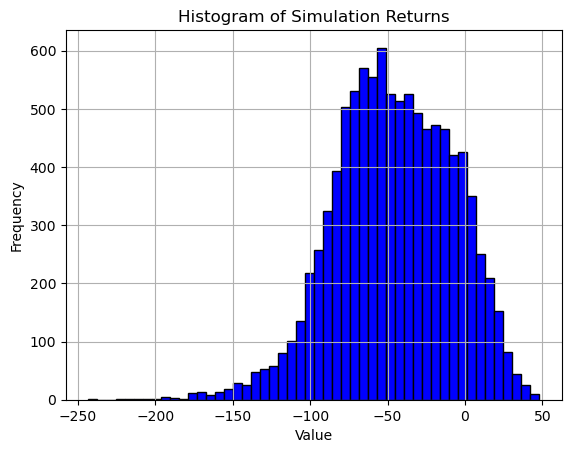

In [10]:
# Plotting the histogram
plt.hist(sac_rewards, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Simulation Returns')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
ddpg_rewards.mean()

-51.425117394722704

In [12]:
ddpg_rewards.std()

35.43336932119792

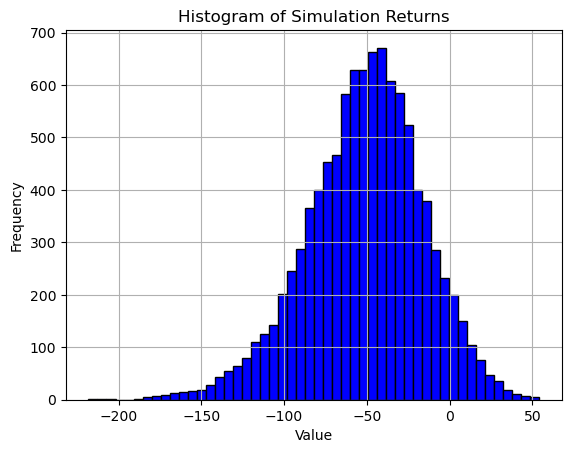

In [13]:
# Plotting the histogram
plt.hist(ddpg_rewards, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Simulation Returns')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [14]:
# Function to evaluate a model
def evaluate_model(model, env, num_episodes=1):
    rewards = []
    for episode in range(num_episodes):
        obs = env.reset()[0]
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            print(action)
            obs, reward, done, _, info = env.step(action)
            print(info, reward)
            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)
sac_rewards_test = evaluate_model(model_ddpg, normalized_env)

[0.23214352]
{'delta': 0.5203262614808536} -5.99523326421623
[0.3991431]
{'delta': 0.5167534690017307} -5.701937717114458
[0.44070786]
{'delta': 0.5513254127120344} -0.8772572310185021
[0.47026968]
{'delta': 0.5282375609626394} -0.988735791593074
[0.48503888]
{'delta': 0.5433035119044569} 1.1524900180702122
[0.500664]
{'delta': 0.5182882621521472} 0.5470420714515962
[0.5144202]
{'delta': 0.5279855376610798} -0.08708950317911113
[0.52872264]
{'delta': 0.490943093104611} 0.05969485929626528
[0.5097754]
{'delta': 0.46865833078380237} 0.8989767963880805
[0.48411384]
{'delta': 0.4751257394030795} 1.2320396395418098
[0.4849336]
{'delta': 0.46203926920437294} 3.0790087986435912
[0.46983412]
{'delta': 0.5108480427096622} 1.023509922634753
[0.494401]
{'delta': 0.489194111378286} 1.683514488373958
[0.49446833]
{'delta': 0.3942121807198534} -0.4026185429117852
[0.4143401]
{'delta': 0.3728466132070727} -3.3802371628954346
[0.3888986]
{'delta': 0.24324323215376448} -5.81536424669027
[0.33862782]
{'